In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fraud_train_raw = pd.read_csv('./data/fraudTrain.csv')
fraud_test_raw = pd.read_csv('./data/fraudTest.csv')

In [3]:
fraud_train = fraud_train_raw.copy()
fraud_test = fraud_test_raw.copy()

In [4]:
fraud_train.shape

(1296675, 23)

In [5]:
fraud_train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
fraud_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

### Feature Engineering

#### Training Data

In [7]:
Time = pd.crosstab(fraud_train['unix_time'], fraud_train['is_fraud'])
time_bin = [0,1330000000,1350000000,1380000000]
time_groups = ['Morning','Evening', 'Night']
fraud_train['Time_Bin'] = pd.cut(fraud_train['unix_time'], time_bin, labels = time_groups)

In [8]:
Amt = pd.crosstab(fraud_train['amt'], fraud_train['is_fraud'])
amt_bin = [0,100,1000,30000]
amt_groups = ['Average','Above Average', 'High']
fraud_train['Amt_Bin'] = pd.cut(fraud_train['amt'], amt_bin, labels = amt_groups)

In [9]:
fraud_train['dob'] = fraud_train['dob'].astype('datetime64[ns]')
DOB = pd.crosstab(fraud_train['dob'], fraud_train['is_fraud'])
dob_bin = [fraud_train['dob'].min(), fraud_train['dob'].mean(), fraud_train['dob'].max()]
dob_groups = ['Adult', 'Young Adult']
fraud_train['Dob_Bin'] = pd.cut(fraud_train['dob'], dob_bin, labels = dob_groups)

#### Testing Data

In [10]:
Time = pd.crosstab(fraud_test['unix_time'], fraud_test['is_fraud'])
time_bin = [0,1330000000,1350000000,1380000000]
time_groups = ['Morning','Evening', 'Night']
fraud_test['Time_Bin'] = pd.cut(fraud_test['unix_time'], time_bin, labels = time_groups)

In [11]:
Amt = pd.crosstab(fraud_test['amt'], fraud_test['is_fraud'])
amt_bin = [0,100,1000,30000]
amt_groups = ['Average','Above Average', 'High']
fraud_test['Amt_Bin'] = pd.cut(fraud_test['amt'], amt_bin, labels = amt_groups)

In [12]:
fraud_test['dob'] = fraud_test['dob'].astype('datetime64[ns]')
DOB = pd.crosstab(fraud_test['dob'], fraud_test['is_fraud'])
dob_bin = [fraud_test['dob'].min(), fraud_test['dob'].mean(), fraud_test['dob'].max()]
dob_groups = ['Adult', 'Young Adult']
fraud_test['Dob_Bin'] = pd.cut(fraud_test['dob'], dob_bin, labels = dob_groups)

In [22]:
fraud_train['is_fraud']

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int64

In [28]:
fraud_test[fraud_test['is_fraud'] ==1].sum()

Unnamed: 0                                                       519212454
trans_date_trans_time    2020-06-21 22:06:392020-06-21 22:32:222020-06-...
cc_num                                                -3361636627378355060
merchant                 fraud_Hamill-D'Amorefraud_Rodriguez, Yost and ...
category                 health_fitnessmisc_netentertainmentshopping_ne...
amt                                                             1133324.68
first                    BrookeDouglasDouglasWilliamBrookeAshleyWilliam...
last                     SmithWillisWillisPerrySmithCabreraPerryPerryPe...
gender                   FMMMFFMMMMMFMFMFFFMFFFMMMMMMMFMMMFMFFFFFFMFFFM...
street                   63542 Luna Brook Apt. 012619 Jeremy Garden Apt...
city                     NotreesBentonBentonDenham SpringsNotreesVero B...
state                    TXWIWILATXFLLALALAWILAFLLAFLLAFLFLFLLAFLFLFLNY...
zip                                                              102665921
lat                      

In [14]:
X_train = fraud_train.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 
                      'first', 'last', 'dob', 'job', 'city', 'state', 'street', 'trans_num', 'unix_time', 'is_fraud'], axis=1)

X_train = pd.get_dummies(X_train)

y_train = fraud_train['is_fraud']

X_test = fraud_test.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 
                      'first', 'last', 'dob', 'job', 'city', 'state', 'street', 'trans_num', 'unix_time', 'is_fraud'], axis=1)

X_test = pd.get_dummies(X_test)

y_test = fraud_test['is_fraud']

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

skf = StratifiedKFold(n_splits=5)
i = 1

for train_index, test_index in skf.split(X_train, y_train):
    print(f'{i} of kfold {skf.n_splits}')
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_tr, y_tr)
    clf_pred = clf.predict(X_val)
    clf_score = accuracy_score(y_val, clf_pred)
    clf_prob = clf.predict_proba(X_val)[:,1]
    print(clf_score, 'accuracy')
    print(mean_squared_error(y_val, clf_pred), 'mean square error')
    i+=1

1 of kfold 5
0.9942121194593865 accuracy
0.005787880540613492 mean square error
2 of kfold 5
0.9942121194593865 accuracy
0.005787880540613492 mean square error
3 of kfold 5
0.9942121194593865 accuracy
0.005787880540613492 mean square error
4 of kfold 5
0.9942121194593865 accuracy
0.005787880540613492 mean square error
5 of kfold 5
0.994208263443037 accuracy
0.005791736556963001 mean square error


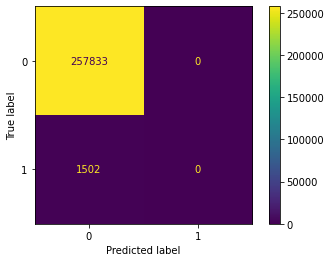

In [48]:
plot_confusion_matrix(clf, X_val, y_val)  
plt.show()  

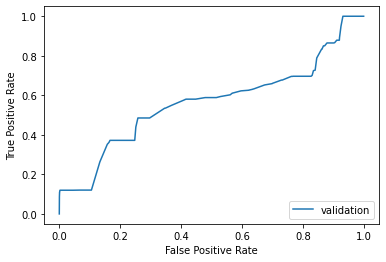

AUC score is 0.563102728170496
Accuracy of the model is 0.994208263443037


In [49]:
clf_fpr, clf_tpr, _ = metrics.roc_curve(y_val, clf_prob, pos_label=1)
clf_auc = metrics.roc_auc_score(y_val, clf_prob)

plt.plot(clf_fpr, clf_tpr, label="validation")
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()
print(f"AUC score is {clf_auc}")
print(f"Accuracy of the model is {clf_score}")

In [51]:
y_pred = clf.predict(X_test)

In [52]:
pred_score = accuracy_score(y_test, y_pred)

In [54]:
print(pred_score, 'accuracy on test data')

0.9961401355721147 accuracy on test data
